In [25]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth', None)

In [3]:
# reading the data
df = pd.read_csv(r"..\data\AAPL Stock Price (15-06-204 and last 4 years).csv", 
                 parse_dates=['Date'], dayfirst=True, index_col='Date')
df.columns = df.columns.str.lower()
df.index = df.index.strftime('%Y-%m-%d')
df.shape

(1008, 5)

In [4]:
display(df.head(),df.tail(),df.sample(5))

,open,high,low,close,volume
Date,,,,,
2020-06-15,83.31,86.42,83.15,85.75,34702230
2020-06-16,87.87,88.30,86.18,88.02,41357182
2020-06-17,88.79,88.85,87.77,87.90,28601626
2020-06-18,87.85,88.36,87.31,87.93,24205096
2020-06-19,88.66,89.14,86.29,87.43,66118952


,open,high,low,close,volume
Date,,,,,
2024-06-10,196.90,197.30,192.15,193.12,97262077
2024-06-11,193.65,207.16,193.63,207.15,172373296
2024-06-12,207.37,220.20,206.90,213.07,198134293
2024-06-13,214.74,216.75,211.60,214.24,97862729
2024-06-14,213.85,215.17,211.30,212.49,70122748


,open,high,low,close,volume
Date,,,,,
2022-08-25,168.78,170.14,168.35,170.03,51218209
2023-06-27,185.89,188.39,185.67,188.06,50730846
2024-03-25,170.57,171.94,169.45,170.85,54288328
2023-09-29,172.02,173.07,170.34,171.21,51861083
2023-09-26,174.82,175.20,171.66,171.96,64588945


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1008 entries, 2020-06-15 to 2024-06-14
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    1008 non-null   float64
 1   high    1008 non-null   float64
 2   low     1008 non-null   float64
 3   close   1008 non-null   float64
 4   volume  1008 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 47.2+ KB


# Feature Engineering

In [6]:
df['moving_avg_10'] = df['close'].rolling(window=10).mean()
df['moving_avg_50'] = df['close'].rolling(window=50).mean()

In [7]:
display(df.head(),df.tail())

,open,high,low,close,volume,moving_avg_10,moving_avg_50
Date,,,,,,,
2020-06-15,83.31,86.42,83.15,85.75,34702230,NaN,NaN
2020-06-16,87.87,88.30,86.18,88.02,41357182,NaN,NaN
2020-06-17,88.79,88.85,87.77,87.90,28601626,NaN,NaN
2020-06-18,87.85,88.36,87.31,87.93,24205096,NaN,NaN
2020-06-19,88.66,89.14,86.29,87.43,66118952,NaN,NaN


,open,high,low,close,volume,moving_avg_10,moving_avg_50
Date,,,,,,,
2024-06-10,196.90,197.30,192.15,193.12,97262077,193.256,179.9666
2024-06-11,193.65,207.16,193.63,207.15,172373296,194.972,180.7090
2024-06-12,207.37,220.20,206.90,213.07,198134293,197.250,181.5936
2024-06-13,214.74,216.75,211.60,214.24,97862729,199.545,182.4854
2024-06-14,213.85,215.17,211.30,212.49,70122748,201.569,183.3588


In [8]:
display(f"Shape of data before dropping null values: {df.shape}")
df = df.dropna()
display(f"Shape of data after dropping null values: {df.shape}")

'Shape of data before dropping null values: (1008, 7)'

'Shape of data after dropping null values: (959, 7)'

# Model Selection

In [9]:
# treating moving average as indepedent variable and closing price as target variable
x = df[['moving_avg_10', 'moving_avg_50']]
y = df['close']

# splitting the data into train and test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [10]:
LinearRegression()

LinearRegression()

In [11]:
def best_model_gridsearch(independent_variables: pd.DataFrame, 
                          dependent_variable: pd.DataFrame) -> pd.DataFrame:
    """This function performs a grid search for the best model among several machine learning algorithms.

    Parameters:
    - independent_variables (pd.DataFrame): A DataFrame containing the independent variables used for prediction.
    - dependent_variable (pd.DataFrame): A DataFrame containing the dependent variable to be predicted.

    Returns:
    - pd.DataFrame: A DataFrame containing the best score achieved by each model, the best parameters used for each model, and the name of the model.
    """
    algorithms = {
        'LinearRegression': {
            'model': LinearRegression(),
            'params': {
                'fit_intercept': [True, False],
                'copy_X': [True, False],
                'n_jobs': [None, 1, 2, 3],
                'positive': [True, False]
            }
        },
        
        'Ridge': {
            'model': Ridge(),
            'params': {
                'alpha': [0.1,1,10,100],
                'fit_intercept': [True, False],
                'copy_X': [True, False],
                'solver': ['auto','svd','cholesky','lsqr', 'sparse_cg', 'sag','saga'],
                'positive': [True, False]
            }
        },
        
        'Lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [0.1,1,10,100],
                'fit_intercept': [True, False],
                'copy_X': [True, False],
                'precompute': [True, False],
                'warm_start':[True, False],
                'selection': ['cyclic', 'random'],
                'positive': [True, False]
            }
        },
        
        'DecisionTree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion': ['squared_error','friedman_mse','absolute_error', 'poisson'],
                'splitter': ['best','random'],
                'max_depth': [None, 10, 20, 30]
            }
        },
        
        'RandomForest': {
            'model': RandomForestRegressor(),
            'params': {
                'n_estimators': [50, 100, 200],
                'max_depth': [None, 10, 20],
                'bootstrap': [True, False],
                'criterion': ['mse', 'mae', 'poisson']
            }
        },
        
#         'SVR': {
#             'model': SVR(),
#             'params': {
#                 'C': [0.1, 1, 10],
#                 'gamma': ['scale', 'auto'],
#                 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
#             }
#         }
    }
    
    scores = []
    cross_validation = ShuffleSplit(n_splits= 5, test_size= 0.2, random_state= 42)
    
    # looping through the dict and configuring grid search
    for algorithm, config in tqdm(algorithms.items(), desc='Grid Searching Models'):
        grid_search = GridSearchCV(config['model'],config['params'],cv=cross_validation,
                                  scoring='neg_mean_squared_error',
                                  return_train_score=False)
        
        # fitting the models
        with tqdm(total=len(config['params']), desc=f"Searching {algorithm}", leave=False) as pbar:
            for param_comb in grid_search.param_grid:
                grid_search.fit(independent_variables, dependent_variable)
                pbar.update(1)
        
        scores.append({
            'model': algorithm,
            'best_score': grid_search.best_score_,
            'best_params': grid_search.best_params_
        })
        
    return pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])

In [15]:
best_model = best_model_gridsearch(independent_variables=x, dependent_variable=y)

Grid Searching Models: 100%|█████████████████████████████████████████████████████████████| 5/5 [07:11<00:00, 86.32s/it]


In [21]:
best_model.sort_values('best_score', ascending=False)

,model,best_score,best_params
4,RandomForest,-13.826217,"{'bootstrap': True, 'criterion': 'poisson', 'max_depth': 20, 'n_estimators': 100}"
1,Ridge,-18.141663,"{'alpha': 100, 'copy_X': False, 'fit_intercept': True, 'positive': False, 'solver': 'saga'}"
2,Lasso,-18.142222,"{'alpha': 0.1, 'copy_X': False, 'fit_intercept': True, 'positive': False, 'precompute': False, 'selection': 'random', 'warm_start': False}"
0,LinearRegression,-18.144833,"{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}"
3,DecisionTree,-18.407965,"{'criterion': 'poisson', 'max_depth': 10, 'splitter': 'best'}"


Random Forest appears to be the best model with the following parameters <br>
`{'bootstrap': True, 'criterion': 'poisson', 'max_depth': 20, 'n_estimators': 100}`

# Model Development

In [27]:
model = RandomForestRegressor(bootstrap=True,criterion='poisson', 
                              max_depth=20, n_estimators=100, random_state=0)
model.fit(x,y)

RandomForestRegressor(criterion='poisson', max_depth=20, random_state=0)

In [28]:
# Evaluate the model
y_pred = model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 1.6868386876624328


# Visualisation

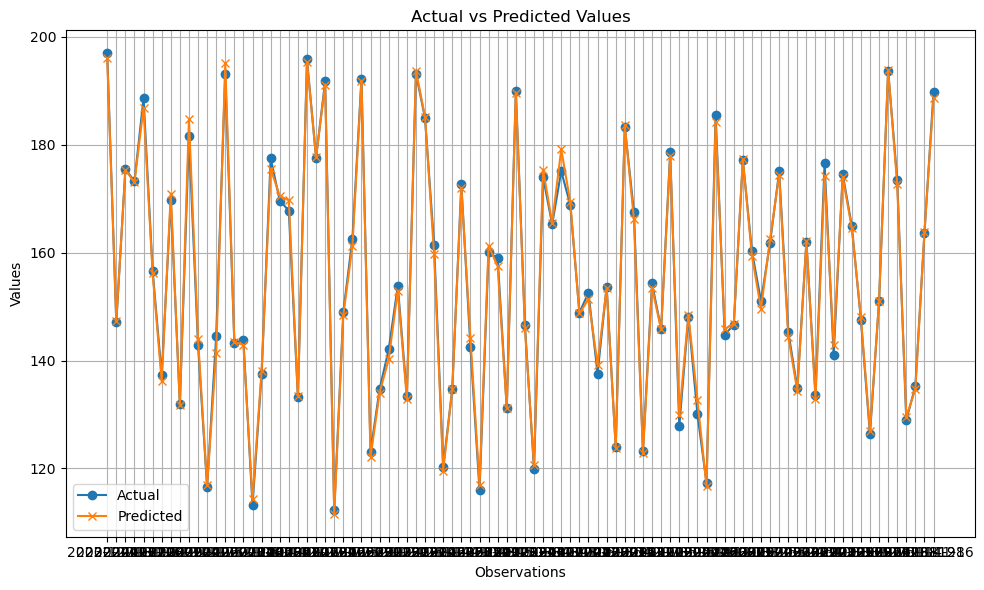

In [38]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.title('Actual vs Predicted Values')
plt.xlabel('Observations')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()